# Framework Libraries

In [4]:
# --- Imports ---   
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.base import MultipleFeaturizer
from pymatgen.core import Composition

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

# Data Collection and Preparation
Draw data ('matbench_expt_gap') from 'Materials Project' database > Cure the dataset > Featurize the dataset using pymatgen 'Composition' object and matminer 'Element property' featurizer (preset= MAGPIE preset)> Save the dataset with proper labeling.

In [5]:
#--- Load Data ---
df = load_dataset("matbench_expt_gap")  # Experimental bandgap dat

df = df.dropna(subset=["composition", "gap expt"])  # Drop NaNs
df["composition"] = df["composition"].apply(Composition)

print(df.columns)
print(df.head(3))

Fetching matbench_expt_gap.json.gz from https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz to c:\Users\sayee\miniconda3\envs\bandgap_env\lib\site-packages\matminer\datasets\matbench_expt_gap.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz in MB: 0.038911999999999995MB [00:00,  9.73MB/s]   


Index(['composition', 'gap expt'], dtype='object')
       composition  gap expt
0      (Ag, Au, S)      0.00
1      (Ag, W, Br)      0.00
2  (Ag, Ge, Pb, S)      1.83


In [6]:
print("Sample compositions:")
print(df["composition"].head())

print("Type check:")
print(type(df["composition"].iloc[0]))

Sample compositions:
0         (Ag, Au, S)
1         (Ag, W, Br)
2     (Ag, Ge, Pb, S)
3    (Ag, Ge, Pb, Se)
4         (Ag, B, Br)
Name: composition, dtype: object
Type check:
<class 'pymatgen.core.composition.Composition'>


In [7]:
# --- Featurize Composition ---
featurizer = ElementProperty.from_preset("magpie")
df_feat = df.copy()
df_feat = featurizer.featurize_dataframe(df_feat, "composition", inplace=False)

MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
ElementProperty: 100%|██████████| 4604/4604 [07:59<00:00,  9.60it/s]


In [8]:
# --- Prepare ML Dataset ---
X = df_feat[featurizer.feature_labels()]
y = df["gap expt"]

In [9]:
X.to_csv('Featurized_composition_Data.csv', index=False)
y.to_csv('Featurized_Band_Gap_Data.csv', index=False)

# Load the saved dataset.
This saves time if a re-run is asked!

In [10]:
# Load from CSV
X = pd.read_csv('Featurized_composition_Data.csv')
y = pd.read_csv('Featurized_Band_Gap_Data.csv')
y = y['gap expt'].tolist()

print(X.shape)
print(len(y))

(4604, 132)
4604


# Train and Test data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

# Initial Models

1. Random Forest

In [4]:
# --- Train Model ---
model_rf = RandomForestRegressor(random_state=42,
                                 verbose= 0)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

2. LightGBM

In [5]:
model_lgbm = LGBMRegressor(random_state=42,
                          verbosity = 0)
model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


LGBMRegressor(random_state=42, verbosity=0)

3. XGBoost

In [6]:
model_xgb = XGBRegressor(random_state=42,
                         verbosity =0)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Initial Evaluation

In [7]:
# --- Evaluate ---
y_pred_rf = model_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RF MAE: {mae_rf:.4f}")
print(f"RF R² Score: {r2_rf:.4f}")

y_pred_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB MAE: {mae_xgb:.3f}")
print(f"XGB R² Score: {r2_xgb:.5f}")

y_pred_lgbm = model_lgbm.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"LGBM MAE: {mae_lgbm:.3f}") 
print(f"LGBM R² Score: {r2_lgbm:.5f}")

RF MAE: 0.4462
RF R² Score: 0.7076
XGB MAE: 0.462
XGB R² Score: 0.73488
LGBM MAE: 0.448
LGBM R² Score: 0.73184


# 'Feature Importance' Analysis using SHAP
SHapley Additive exPlanations:
SHAP is based on Shapley values, a concept from game theory where:Each feature is seen as a "player" in a game. The prediction is the "payout" or "value" of the game.
The Shapley value for a feature represents its average marginal contribution across all possible combinations (coalitions) of features.

In SHAP:
One calculate how much each feature contributes to the difference between the actual prediction and the average prediction. SHAP explains the model prediction as: f(x) = E[f(x)] + φ1 + φ2 + ... + φM
Where:
f(x) = actual prediction, E[f(x)] = average prediction, φi = SHAP value (contribution) of feature i, M = number of features.
This ensures fair, consistent, and locally accurate attribution. 
Game theory in SHAP means fairly distributing the model output among input features, just like fairly splitting profits among players in a cooperative game.

# SHAP PLOT 1:
Using all the features and the non_optimized models.

In [8]:
explainer_rf= shap.TreeExplainer(model_rf)
shap_values_rf = explainer_rf(X_test)

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

explainer_lgbm = shap.TreeExplainer(model_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)

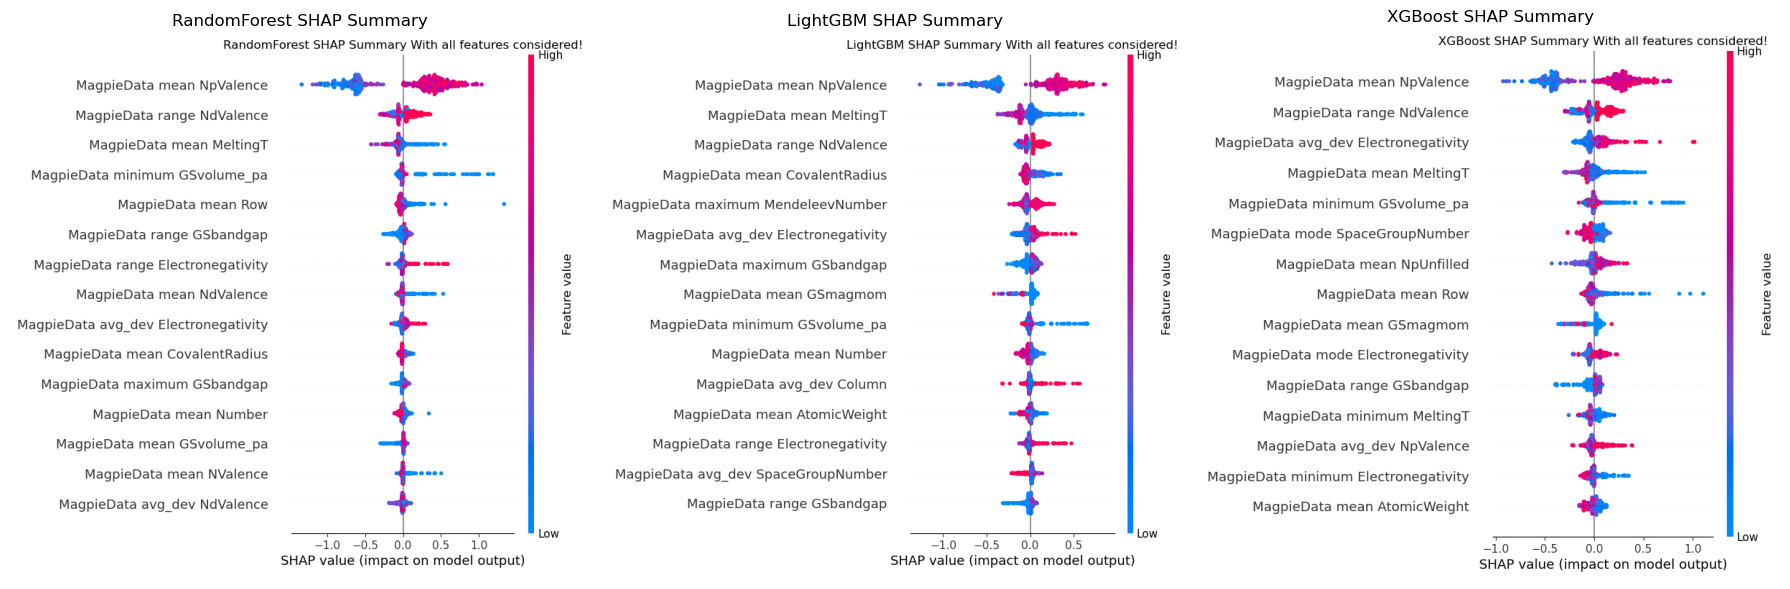

In [9]:
# --- Generate summary plots separately and save to file ---
shap.summary_plot(shap_values_xgb, X_test, plot_type="dot", max_display=15, show=False)
plt.title("XGBoost SHAP Summary With all features considered!")
plt.savefig("shap_summary_xgb.png", bbox_inches='tight')
plt.close()

shap.summary_plot(shap_values_lgbm, X_test, plot_type="dot", max_display=15, show=False)
plt.title("LightGBM SHAP Summary With all features considered!")
plt.savefig("shap_summary_lgbm.png", bbox_inches='tight')
plt.close()

# Save the full SHAP beeswarm plot
shap.summary_plot(shap_values_rf, X_test, plot_type= "dot", max_display=15, show=False)
plt.title("RandomForest SHAP Summary With all features considered!")
plt.savefig("shap_summary_rf.png", bbox_inches='tight')
plt.close()

# --- Load saved plots and display side-by-side ---
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Load and show saved images
axes[0].imshow(mpimg.imread("shap_summary_rf.png"))
axes[0].axis('off')
axes[0].set_title("RandomForest SHAP Summary")

axes[1].imshow(mpimg.imread("shap_summary_lgbm.png"))
axes[1].axis('off')
axes[1].set_title("LightGBM SHAP Summary")

axes[2].imshow(mpimg.imread("shap_summary_xgb.png"))
axes[2].axis('off')
axes[2].set_title("XGBoost SHAP Summary")

plt.tight_layout()
plt.show()

# Reduced Features

I plan to optimize the number of features in the training set in three steps.
1. Start with 50% features (Based on initial model performances) and optimize the hyperparameters. Then Search for optimum feaurures with the first optimized model.This step will study how a non-optimized feature selection (first assumption) influences the model_structure optimization. Step 1 will be deleted and wont appear in final comparision during model report.
2. If the step 1 returns any anomality (e.g., No of features being less than the max_features of random forest algorithm), Optimize the no. of features with the non.-optimized model. The lower limit of the exploration range will be $\sqrt{n}$ . Later it will be modified according to the results of this search.
3. After step 2, Optimize the model structure, then optimize the features again down the line.

In [10]:
# --- Get mean absolute SHAP values for each feature ---

shap_importance_xgb = np.abs(shap_values_xgb).mean(axis=0)
shap_importance_lgbm = np.abs(shap_values_lgbm).mean(axis=0)

shap_values_rf_array = shap_values_rf.values   # The output -Type- SHAP summary values for Random forest is  # <class 'shap._explanation.Explanation'>. So we need to acces the values attribute of that object.
shap_importance_rf = np.abs(shap_values_rf_array).mean(axis=0)

# --- Create Pandas Series for easy sorting ---
shap_series_xgb = pd.Series(shap_importance_xgb, index=X_test.columns)
shap_series_lgbm = pd.Series(shap_importance_lgbm, index=X_test.columns)
shap_series_rf = pd.Series(shap_importance_rf, index=X_test.columns)

#  Features Optimization 1: Not-optmized model
1. Random Forest Regressor

🔝 Top 3 feature counts by R² score:
1. k = 27, R² = 0.7218
2. k = 37, R² = 0.7184
3. k = 34, R² = 0.7179


Text(0, 0.5, 'R² Score')

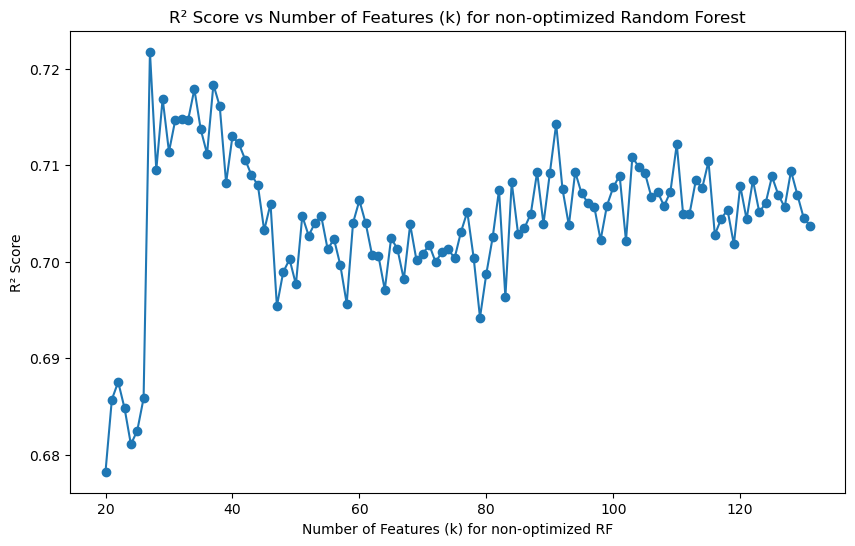

In [47]:
feature_counts_primary = range(20, 132, 1)
results_rf_bayes_primary = {}

# --- Random Forest ---
for k in feature_counts_primary:
    selected_features = shap_series_rf.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned RF
    model_rf_bayes = RandomForestRegressor(random_state=42, verbose= 0)
    model_rf_bayes.fit(X_train_k, y_train)
    preds_rf_bayes = model_rf_bayes.predict(X_test_k)
    results_rf_bayes_primary[k] = r2_score(y_test, preds_rf_bayes)

top_3_feat_choice_primary = sorted(results_rf_bayes_primary.items(), key=lambda x: x[1], reverse=True)[:3]

print("🔝 Top 3 feature counts by R² score:")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_primary, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")
   
plt.figure(figsize=(10, 6))
plt.plot(feature_counts_primary, list(results_rf_bayes_primary.values())  , label="RF - Bayes", marker='o')
plt.xlabel("Number of Features (k) for non-optimized RF")
plt.title("R² Score vs Number of Features (k) for non-optimized Random Forest")
plt.ylabel("R² Score")

2. XGBoost

🔝 Top 3 feature counts by R² score for XGBoost:
1. k = 73, R² = 0.7531
2. k = 41, R² = 0.7485
3. k = 39, R² = 0.7476


Text(0, 0.5, 'R² Score')

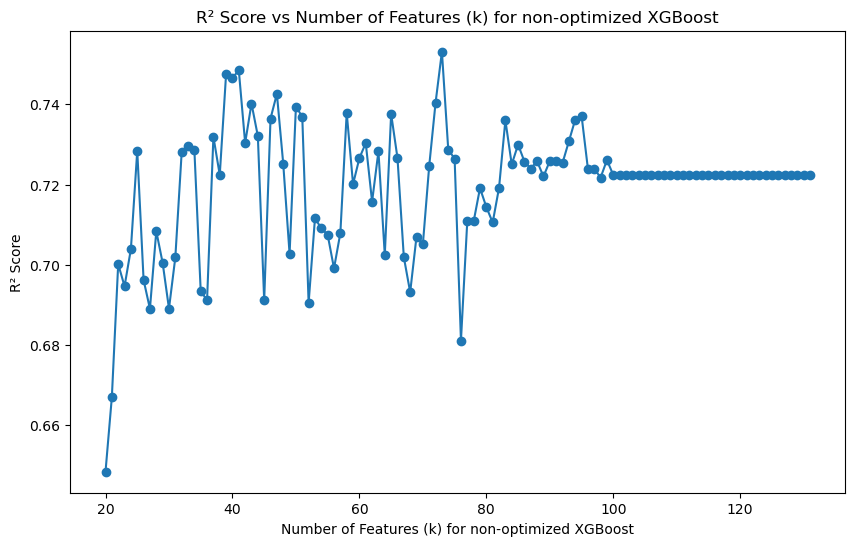

In [48]:
results_xgb_bayes_primary = {}
# --- XGBoost ---
for k in feature_counts_primary:
    selected_features = shap_series_xgb.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned XGB
    model_xgb_bayes = XGBRegressor(random_state=42, verbosity=0)
    model_xgb_bayes.fit(X_train_k, y_train)
    preds_xgb_bayes = model_xgb_bayes.predict(X_test_k)
    results_xgb_bayes_primary[k] = r2_score(y_test, preds_xgb_bayes)

top_3_feat_choice_xgb_primary = sorted(results_xgb_bayes_primary.items(), key=lambda x: x[1], reverse=True)[:3]
print("🔝 Top 3 feature counts by R² score for XGBoost:")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_xgb_primary, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(feature_counts_primary, list(results_xgb_bayes_primary.values()), label="XGB - Bayes", marker='o')
plt.xlabel("Number of Features (k) for non-optimized XGBoost")
plt.title("R² Score vs Number of Features (k) for non-optimized XGBoost")
plt.ylabel("R² Score") 

3. LightGBM

🔝 Top 3 feature counts by R² score for LightGBM:
1. k = 67, R² = 0.7529
2. k = 68, R² = 0.7486
3. k = 90, R² = 0.7483


Text(0.5, 1.0, 'R² Score vs Number of Features (k) for non-optimized LightGBM')

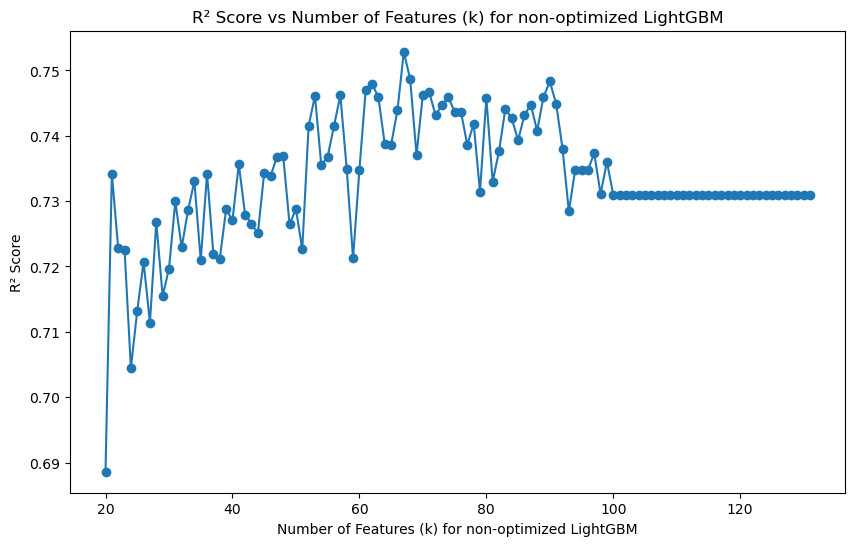

In [49]:
results_lgbm_bayes_primary = {}

for k in feature_counts_primary:
    selected_features = shap_series_lgbm.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned LGBM
    model_lgbm_bayes = LGBMRegressor(random_state=42, verbosity=-1)
    
    model_lgbm_bayes.fit(X_train_k, y_train)
    preds_lgbm_bayes = model_lgbm_bayes.predict(X_test_k)
    results_lgbm_bayes_primary[k] = r2_score(y_test, preds_lgbm_bayes)
    
top_3_feat_choice_lgbm_primary = sorted(results_lgbm_bayes_primary.items(), key=lambda x: x[1], reverse=True)[:3]
print("🔝 Top 3 feature counts by R² score for LightGBM:")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_lgbm_primary, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")
    
plt.figure(figsize=(10, 6))
plt.plot(feature_counts_primary, list(results_lgbm_bayes_primary.values()), label="LGBM - Bayes", marker='o')
plt.xlabel("Number of Features (k) for non-optimized LightGBM")
plt.ylabel("R² Score")
plt.title("R² Score vs Number of Features (k) for non-optimized LightGBM")

The best fraction of features found by the preceding studies, will be used to find the optimum structure of the model.  
k_rf = 27, R² = 0.7218, k_xgb = 73, R² = 0.7531, k_lgbm = 67, R² = 0.7529 

In [50]:
# --- Get top features ---
top_features_xgb = shap_series_xgb.sort_values(ascending=False).head(73).index
top_features_lgbm = shap_series_lgbm.sort_values(ascending=False).head(67).index
top_features_rf = shap_series_rf.sort_values(ascending=False).head(27).index

# --- Subset original data while sticking to the original data-split. ---
X_train_xgb = X_train[top_features_xgb]
X_test_xgb = X_test[top_features_xgb]

X_train_lgbm = X_train[top_features_lgbm]
X_test_lgbm = X_test[top_features_lgbm]

X_train_rf = X_train[top_features_rf]
X_test_rf = X_test[top_features_rf] 

In [ ]:
# X_train_lgbm.shape

(4143, 66)

# Retraining 
with top features and not_optimized models

In [64]:
model_xgb_top_feat = XGBRegressor(random_state=42, verbosity=0)
model_xgb_top_feat.fit(X_train_xgb, y_train)

model_lgbm_top_feat = LGBMRegressor(random_state=42, verbosity=0)
model_lgbm_top_feat.fit(X_train_lgbm, y_train)

model_rf_top_feat = RandomForestRegressor(random_state=42, verbose=0)
model_rf_top_feat.fit(X_train_rf, y_train)

# --- Evaluate models with top 50 features ---
y_pred_xgb_top_feat = model_xgb_top_feat.predict(X_test_xgb)
y_pred_lgbm_feat = model_lgbm_top_feat.predict(X_test_lgbm)
y_pred_rf_feat = model_rf_top_feat.predict(X_test_rf)

print(f"Top-Features-Basic-Model XGB MAE: {mean_absolute_error(y_test, y_pred_xgb_top_feat):.3f}")
print(f"Top-Features-Basic-Model XGB R²: {r2_score(y_test, y_pred_xgb_top_feat):.4f}")

print(f"Top-Features-Basic-Model LGBM MAE: {mean_absolute_error(y_test, y_pred_lgbm_feat):.3f}")
print(f"Top-Features-Basic-ModelLGBM R²: {r2_score(y_test, y_pred_lgbm_feat):.4f}")

print(f"Top-Features-Basic-Model RF MAE: {mean_absolute_error(y_test, y_pred_rf_feat):.3f}")
print(f"Top-Features-Basic-Model RF R²: {r2_score(y_test, y_pred_rf_feat):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Top-Features-Basic-Model XGB MAE: 0.442
Top-Features-Basic-Model XGB R²: 0.7531
Top-Features-Basic-Model LGBM MAE: 0.437
Top-Features-Basic-ModelLGBM R²: 0.7529
Top-Features-Basic-Model RF MAE: 0.452
Top-Features-Basic-Model RF R²: 0.7218


# Whether
1. weighting the features according to their importance value improves performance.

In [ ]:
# # 2. Normalize the SHAP values for the top features to create weights
# weights = feature_importance_sorted.loc[top_features] / feature_importance_sorted.loc[top_features].sum()
# # 3. Apply weights to training and testing data
# X_train_weighted = X_train[top_features].copy()
# X_test_weighted = X_test[top_features].copy()

# for col in top_features:
#     X_train_weighted[col] *= weights[col]
#     X_test_weighted[col] *= weights[col]

# # 4. Train model with best hyperparameters from Bayesian optimization
# model_weighted = RandomForestRegressor(random_state=42,
#                                        n_estimators = 50,
#                                        max_depth = 32,
#                                        max_features = 'sqrt'
#                                        )
# model_weighted.fit(X_train_weighted, y_train)

# # 5. Predict and evaluate
# y_pred_weighted = model_weighted.predict(X_test_weighted)
# r2_weighted = r2_score(y_test, y_pred_weighted)
# mae_weighted = mean_absolute_error(y_test, y_pred_weighted)

# print("R² after SHAP weighting:", r2_weighted)
# print("MAE after SHAP weighting:", mae_weighted)

# Model Comparisions

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Define models with default parameters (you can tune later)
models = {
    "Random Forest": model_reduced_re,  # Your optimized model
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# Evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_reduced_re, y_train)
    y_pred = model.predict(X_test_reduced_re)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {"R2": r2, "MAE": mae}

# Display the results
import pandas as pd
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print(results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6950
[LightGBM] [Info] Number of data points in the train set: 4143, number of used features: 50
[LightGBM] [Info] Start training from score 0.973121
                         R2       MAE
XGBoost            0.699534  0.474577
Random Forest      0.685636  0.465487
LightGBM           0.683825  0.487958
Gradient Boosting  0.596489  0.591780
KNN                0.436669  0.601171
SVR                0.087088  0.846804


# Hyperparameter Tuning and Feature Selection Optimization
Bayesian Optimization, RandomSearchCV & Optuna  will be used for cross-comparision. RandomSearchCV underperformed for RandomForest model and not cariied out further.
### 🔍 Difference Between Optuna and BayesSearchCV for Hyperparameter Tuning

| Feature                              | BayesSearchCV                              | Optuna                                     |
|--------------------------------------|---------------------------------------------|--------------------------------------------|
| Fits models automatically            | ✅ Yes (during `.fit()`)                     | ❌ No (you define the training logic)       |
| Returns best trained model           | ✅ `best_estimator_` available               | ❌ Only best parameters (`study.best_params`) |
| Manual retraining needed             | ❌ No                                        | ✅ Yes                                      |
| Evaluation approach                  | Built-in cross-validation                   | You must define CV (e.g., with `cross_val_score`) |
| Prediction after `.fit()` works      | ✅ Yes                                       | ❌ Not applicable until you retrain         |
| Model object returned                | Trained estimator with best params          | Just parameter dictionary (`dict`)         |

In short, we: 
Use `BayesSearchCV` when we want an easy, plug-and-play hyperparameter search with built-in CV and automatic training.  
Use `Optuna` when we need fine-grained control over the search process, pruning, or custom logic >> manual retraining needed using `study.best_params`.


In [53]:
from skopt import BayesSearchCV
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.integration import LightGBMPruningCallback
import joblib

from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import cross_val_score, KFold

# RandomizedSearchCV
Computationally expensive and less probable to converge than bayesian optimization. Used only for the random forest to visualize thedifference in optimizability.

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Define the parameter space
# param_distributions = {
#     "n_estimators": randint(100, 500),
#     "max_depth": randint(5, 50),
#     "max_features": randint(40, 50)
# }

# # Initialize base model
# rf_rdm = RandomForestRegressor(random_state=42)

# # Setup RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=rf_rdm,
#     param_distributions=param_distributions,
#     n_iter=50,
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1,
#     scoring='r2'
# )

# # Fit on reduced feature training data
# random_search.fit(X_train_reduced_re, y_train)

# # Best model
# best_rf = random_search.best_estimator_

# # Predict and evaluate
# y_pred_tuned = best_rf.predict(X_test_reduced_re)
# r2_tuned = r2_score(y_test, y_pred_tuned)
# mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

# print("R² after tuning:", r2_tuned)
# print("MAE after tuning:", mae_tuned)
# print("Best parameters found:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
R² after tuning: 0.6834910125809799
MAE after tuning: 0.47121696280793857
Best parameters found: {'max_depth': 20, 'max_features': 42, 'n_estimators': 463}


# Optimized Featureset for Non Optimized Models:
k_rf = 27, R² = 0.7218,  
k_xgb = 73, R² = 0.7531,   
k_lgbm = 67, R² = 0.7529 

# Bayesian Optimization
1. Random Forest

In [63]:
import warnings
warnings.filterwarnings("ignore")

main_search_space_rf = {
    'n_estimators': Integer(100, 1000),                                      # default: 100
    'max_depth': Categorical([None] + list(range(10, 101))),                 # default: None, explore 10–50
    'max_features': Categorical(['sqrt', 'log2'] + list(range(8, 28))),      # default: 1.0 (interpreted), allow categorical + int
    'min_samples_split': Integer(2, 50),                                     # default: 2
    'min_samples_leaf': Integer(1.0, 10),                                    # default: 1
    'max_samples': Real(0.1, 1.0),                                           # default (None → full dataset)
    'oob_score': Categorical([False, True]),                                 # default: False
    'warm_start': Categorical([False, True])                                 # default: False
}

# Define default parameter configuration to force evaluation
default_params_rf ={
    # 'n_estimators': Categorical([100]),
    # 'max_depth': Categorical([None]),
    # 'max_features': Categorical([27]),
    # 'min_samples_split': Categorical([2]),
    # 'min_samples_leaf': Categorical([1]),
    # 'max_samples': Categorical([1.0]),
    # 'oob_score': Categorical([False]),
    # 'warm_start': Categorical([False]),
    'verbose' : Categorical([0]),  # Set verbose to 0 for no output during fitting
    'random_state': Categorical([42])  # Ensure reproducibility
} 

# Compose search_spaces as a list of (space, n_iter) pairs
search_space_rf = [
    (default_params_rf, 1),        # Force 1 evaluation of the default config
    (main_search_space_rf, 99) ]   # Remaining search iterations

# Create the BayesSearchCV object
opt_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=search_space_rf,
    n_iter=100,  # number of iterations, i.e., number of different parameter combinations to try
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Fit to the reduced feature training data
opt_rf.fit(X_train_rf, y_train)  

# Predict and evaluate on the test set
y_pred_red_rf = opt_rf.predict(X_test_rf)
r2_bayes_red_rf = r2_score(y_test, y_pred_red_rf)
mae_bayes_red_rf = mean_absolute_error(y_test, y_pred_red_rf)


print("R² after Bayesian optimization with reduced features training set:", r2_bayes_red_rf)
print("MAE after Bayesian optimization:", mae_bayes_red_rf)
print("Best parameters found:", opt_rf.best_params_)

R² after Bayesian optimization with reduced features training set: 0.718889149714212
MAE after Bayesian optimization: 0.46357587309874415
Best parameters found: OrderedDict([('max_depth', 34), ('max_features', 11), ('max_samples', 1.0), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000), ('oob_score', False), ('warm_start', False)])


2. XGBoost

In [60]:
import warnings
warnings.filterwarnings("ignore")

#Define the search space
main_search_space_xgb = {
    'n_estimators': Integer(100, 1000),                          # default=100
    'max_depth': Integer(6, 50),                                 # default=6
    'learning_rate': Real(0.01, 0.5, prior='uniform'),           # default=0.3
    'subsample': Real(0.5, 1.0),                                 # default=1.0
    'colsample_bytree': Real(0.3, 1.0),                          # default=1.0
    'reg_alpha': Real(1e-8, 10.0, prior='log-uniform'),          # default=0
    'reg_lambda': Real(1e-8, 10.0, prior='log-uniform'),         # default=1
    'gamma': Real(0, 5),                                         # default=0
}

default_params_xgb = {
    'n_estimators': Categorical([100]),
    'max_depth': Categorical([6]),
    'learning_rate': Categorical([0.3]),
    'subsample': Categorical([1.0]),
    'colsample_bytree': Categorical([1.0]),
    'reg_alpha': Categorical([0.0]),
    'reg_lambda': Categorical([1.0]),
    'gamma': Categorical([0.0])
}

search_space_xgb = [
    (default_params_xgb, 1),    # 1 forced evaluation of default config
    (main_search_space_xgb, 99)        # 49 Bayesian iterations
]


opt_xgb = BayesSearchCV (
    
    estimator=XGBRegressor(random_state=42, verbosity=0),
    search_spaces=search_space_xgb,
    n_iter=100,  # Increasing this would lead to more thorough search
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0,
    random_state=42
    )


# Fit to the reduced feature training data
opt_xgb.fit(X_train_xgb, y_train)

# Predict and evaluate on the test set
y_pred_opt_xgb= opt_xgb.predict(X_test_xgb)
r2_xgb_opt = r2_score(y_test, y_pred_opt_xgb)
mae_xgb_opt = mean_absolute_error(y_test, y_pred_opt_xgb)

print("R² for xgboost after Bayesian optimization:", r2_xgb_opt)
print("MAE for xgboost after Bayesian optimization:", mae_xgb_opt)
print("Best parameters found:", opt_xgb.best_params_)

R² for xgboost after Bayesian optimization: 0.7637168765068054
MAE for xgboost after Bayesian optimization: 0.4102608859539032
Best parameters found: OrderedDict([('colsample_bytree', 0.35638495679812116), ('gamma', 0.0), ('learning_rate', 0.13425429947962628), ('max_depth', 33), ('n_estimators', 1000), ('reg_alpha', 0.3343417337155307), ('reg_lambda', 10.0), ('subsample', 0.9201475922066067)])


3. LightGBM

In [62]:
import warnings
warnings.filterwarnings("ignore")

# Define the search space including defaults and categorical params
main_search_space_lgbm = {
    
    "learning_rate": Real(0.01, 0.5, prior="log-uniform"),      # default: 0.1
    "num_leaves": Integer(31, 512),                             # default: 31, but we allow larger values 
    "max_depth": Categorical([-1] + list(range(30, 51))),       # default: -1 (unlimited), but we allow 30-50 for exploration
    "min_child_samples": Integer(20, 100),                      # default: 20, but we explore some higher values
    "n_estimators": Integer(100, 1000),                         # default: 100
    "subsample": Real(0.5, 1.0),                                # default: 1.0 (if boosting='gbdt')
    "colsample_bytree": Real(0.5, 1.0),                         # default: 1.0
    "reg_alpha": Real(1e-8, 10.0, prior="log-uniform"),         # default: 0.0, but we allow larger values for exploration
    "reg_lambda": Real(1e-8, 10.0, prior="log-uniform")         # default: 0.0, but we allow larger values for exploration
 }

# Step 1: Wrap default configuration as single-point Categorical search space
default_params_lgbm = {
    # "learning_rate": Categorical([0.1]),
    # "num_leaves": Categorical([31]),
    # "max_depth": Categorical([-1]),
    # "min_child_samples": Categorical([20]),
    # "n_estimators": Categorical([100]),
    # "subsample": Categorical([1.0]),
    # "colsample_bytree": Categorical([1.0]),
    # "reg_alpha": Categorical([0.0]),
    # "reg_lambda": Categorical([0.0]),
    "random_state": Categorical([42]),
    "verbosity": Categorical([-1])    
    
}
# Step 2: Compose search_spaces as a list of (space, n_iter) pairs
search_spaces = [
    (default_params_lgbm, 1),                # Force 1 evaluation of the default model
    (main_search_space_lgbm, 99)             # Remaining search iterations
]

# Bayesian optimization
opt_lgbm = BayesSearchCV(
    estimator=LGBMRegressor(random_state=42, verbosity=-1),
    search_spaces=search_spaces,
    n_iter=100,  # deeper exploration
    scoring="r2",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose= 0
)

# Fit with training data
opt_lgbm.fit(X_train_lgbm, y_train)

# Predict and evaluate
y_pred_bayes_lgbm = opt_lgbm.predict(X_test_lgbm)
r2_bayes_lgbm = r2_score(y_test, y_pred_bayes_lgbm)
mae_bayes_lgbm = mean_absolute_error(y_test, y_pred_bayes_lgbm)

print(f"Bayes optimized LGBM R²: {r2_bayes_lgbm:.4f}")
print("MAE for LGBM after Bayesian optimization:", mae_bayes_lgbm)
print("Best parameters found:", opt_lgbm.best_params_)

Bayes optimized LGBM R²: 0.7516
MAE for LGBM after Bayesian optimization: 0.4220858066492864
Best parameters found: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.02149411536747437), ('max_depth', 33), ('min_child_samples', 20), ('n_estimators', 1000), ('num_leaves', 512), ('reg_alpha', 1e-08), ('reg_lambda', 1e-08), ('subsample', 0.5)])


# Optuna
Optuna (An open source hyperparameter optimization framework to automate hyperparameter search) is reported to be more efficient for tree based models.

1. Random Forest

In [18]:
import warnings
warnings.filterwarnings("ignore")
import optuna
from sklearn.model_selection import cross_val_score, KFold

def objective_rf_cv(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_categorical('max_depth', [None] + list(range(10, 51))),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'] + list(range(30, 67))),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 1e-5, 0.999),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
        'oob_score': trial.suggest_categorical('oob_score', [False, True]), 
        'warm_start': trial.suggest_categorical('warm_start', [False, True])
        }
    
    model = RandomForestRegressor(random_state=42, **params)
    # 5-fold CV score
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_rf, y_train, cv=cv, scoring="r2", n_jobs=-1)
    return score.mean()

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the study
optuna_rf_study = optuna.create_study(direction="maximize")
optuna_rf_study.optimize(objective_rf_cv, n_trials=100)

# Save study (optional)
joblib.dump(optuna_rf_study, "optuna_rf_study_cv.pkl")

# Train final model using best params
optuna_rf_model = RandomForestRegressor(**optuna_rf_study.best_params, random_state=42, n_jobs=-1)
optuna_rf_model.fit(X_train_rf, y_train)

# Test set evaluation
y_pred_optuna_rf = optuna_rf_model.predict(X_test_rf)
r2_optuna_rf = r2_score(y_test, y_pred_optuna_rf)
mae_optuna_rf = mean_absolute_error(y_test, y_pred_optuna_rf)

print(f"Optuna (CV-based) RF R²: {r2_optuna_rf:.4f}")
print(f"MAE: {mae_optuna_rf:.4f}")
print("Best parameters from Optuna:", optuna_rf_study.best_params)

Optuna (CV-based) RF R²: 0.6838
MAE: 0.4874
Best parameters from Optuna: {'n_estimators': 752, 'max_depth': 35, 'max_features': 40, 'min_samples_split': 12, 'min_samples_leaf': 0.0008467787903616814, 'max_samples': 0.7744737746698602, 'oob_score': False, 'warm_start': True}


2.  XGBoost

In [21]:
import warnings
warnings.filterwarnings("ignore")

# 🔍 Objective function using cross-validation
def objective_xgb_cv(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "verbosity": 0,
        "random_state": 42
    }

    model = XGBRegressor(**params)

    # 5-fold CV score
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_xgb, y_train, cv=cv, scoring="r2", n_jobs=-1)
    return score.mean()

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 🔧 Run the Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_xgb_study = optuna.create_study(direction="maximize")
optuna_xgb_study.optimize(objective_xgb_cv, n_trials=100)

# 💾 Save the study
joblib.dump(optuna_xgb_study, "optuna_xgb_study_cv.pkl")

# ✅ Train final model with best params on full training set
optuna_xgb_model = XGBRegressor(**optuna_xgb_study.best_params, random_state=42, verbosity=0)
optuna_xgb_model.fit(X_train_xgb, y_train)

# 🧪 Evaluate on test set
y_pred_optuna_xgb = optuna_xgb_model.predict(X_test_xgb)
r2_optuna_xgb = r2_score(y_test, y_pred_optuna_xgb)
mae_optuna_xgb = mean_absolute_error(y_test, y_pred_optuna_xgb)

print(f"Optuna (CV-based) XGBoost R²: {r2_optuna_xgb:.4f}")
print(f"MAE: {mae_optuna_xgb:.4f}")
print("Best parameters from Optuna:", optuna_xgb_study.best_params)

Optuna (CV-based) XGBoost R²: 0.7342
MAE: 0.4254
Best parameters from Optuna: {'n_estimators': 541, 'max_depth': 32, 'learning_rate': 0.011468478379325372, 'subsample': 0.51474324562737, 'colsample_bytree': 0.5229140693225288, 'reg_alpha': 0.00043724953355646985, 'reg_lambda': 1.5713017844647804e-08, 'gamma': 0.009264370468634736}


3. LightGBM

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold

def objective_lgbm_cv(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 512),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "n_estimators": 1000,
        "random_state": 42,
        "verbosity": -1,
        "n_jobs": -1
    }

    model = LGBMRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_lgbm, y_train, cv=cv, scoring="r2", n_jobs=-1)
    return scores.mean()

# Run Optuna study
optuna_lgbm_study = optuna.create_study(direction="maximize")
optuna_lgbm_study.optimize(objective_lgbm_cv, n_trials=100, show_progress_bar=True)

# Save the study
import joblib
joblib.dump(optuna_lgbm_study, "optuna_lgbm_study_cv.pkl")

# Train final model using best params
optuna_lgbm_model = LGBMRegressor(**optuna_lgbm_study.best_params, random_state=42, verbosity=-1, n_jobs=-1)
optuna_lgbm_model.fit(X_train_lgbm, y_train)

# Evaluate on test set
from sklearn.metrics import r2_score, mean_absolute_error

y_pred_optuna_lgbm = optuna_lgbm_model.predict(X_test_lgbm)
r2_optuna_lgbm = r2_score(y_test, y_pred_optuna_lgbm)
mae_optuna_lgbm = mean_absolute_error(y_test, y_pred_optuna_lgbm)

print(f"Optuna optimized LGBM R²: {r2_optuna_lgbm:.4f}")
print(f"MAE for LGBM after Optuna optimization: {mae_optuna_lgbm:.4f}")
print("Best parameters found by Optuna:", optuna_lgbm_study.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimized LGBM R²: 0.6946
MAE for LGBM after Optuna optimization: 0.5091
Best parameters found by Optuna: {'learning_rate': 0.027274710456837544, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8683870124141965, 'colsample_bytree': 0.8277836203502793, 'reg_alpha': 0.0028858060948711854, 'reg_lambda': 1.3295041850092154e-05}


In [ ]:
#print(model_xgb.get_params())
#print(model_lgbm.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0}


*** Optimized Model and Their Parameters *** 

1.  Top-Features-Bayes_Optimized-Model RF R² : 0.718889149714212  
    Top-Features-Bayes_Optimized-Model RF MAE : 0.46357587309874415  
    Best parameters found: OrderedDict([('max_depth', 34), ('max_features', 11), ('max_samples', 1.0), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000), ('oob_score', False), ('warm_start', False)])
2.  Top-Features-Bayes_Optimized-Model XGB R²: 0.7637168765068054  
    Top-Features-Bayes_Optimized-Model MAE : 0.4102608859539032  
    Best parameters found: OrderedDict([('colsample_bytree', 0.35638495679812116), ('gamma', 0.0), ('learning_rate', 0.13425429947962628), ('max_depth', 33), ('n_estimators', 1000), ('reg_alpha', 0.3343417337155307), ('reg_lambda', 10.0), ('subsample', 0.9201475922066067)])
3.  Top-Features-Bayes_Optimized-Model LGBM R²: 0.7516  
    Top-Features-Bayes_Optimized-Model LGBM MAE : 0.4220858066492864  
    Best parameters found: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.02149411536747437), ('max_depth', 33), ('min_child_samples', 20), ('n_estimators', 1000), ('num_leaves', 512), ('reg_alpha', 1e-08), ('reg_lambda', 1e-08), ('subsample', 0.5)])

*** Non-Optimized Model ***  
Top-Features-Basic-Model XGB MAE: 0.442  
Top-Features-Basic-Model XGB R²: 0.7531  
Top-Features-Basic-Model LGBM MAE: 0.437  
Top-Features-Basic-ModelLGBM R²: 0.7529  
Top-Features-Basic-Model RF MAE: 0.452  
Top-Features-Basic-Model RF R²: 0.7218  

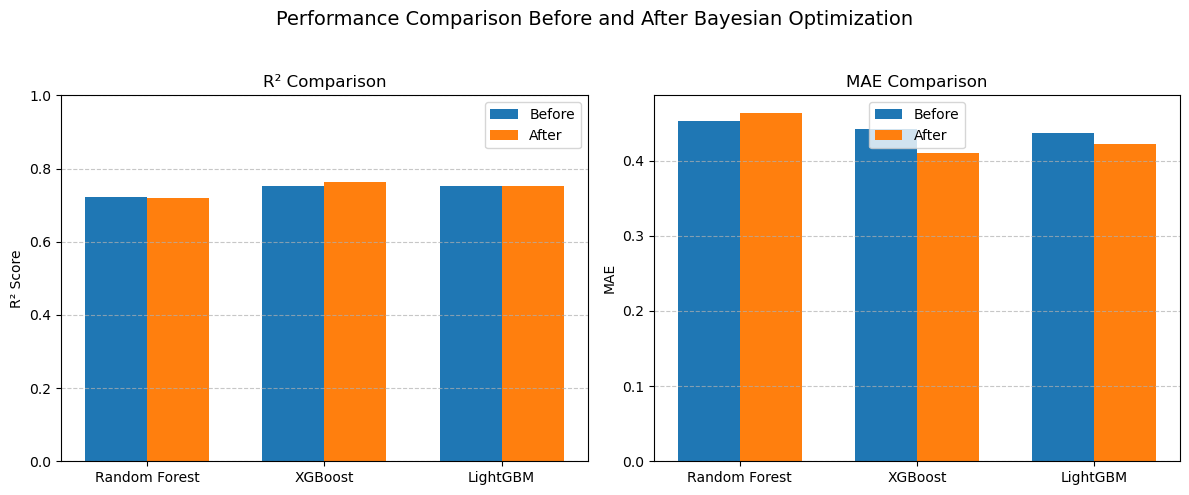

In [65]:
models = ['Random Forest', 'XGBoost', 'LightGBM']

r2_before = [0.7218, 0.7531, 0.7529]
r2_after = [0.7189, 0.7637, 0.7516]
mae_before = [0.452, 0.442, 0.437]
mae_after = [0.4636, 0.4103, 0.4221]

# Bar width and x positions
bar_width = 0.35
x = np.arange(len(models))

# Plot R² comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot R²
axs[0].bar(x - bar_width/2, r2_before, width=bar_width, label='Before')
axs[0].bar(x + bar_width/2, r2_after, width=bar_width, label='After')
axs[0].set_title('R² Comparison')
axs[0].set_ylabel('R² Score')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend()
axs[0].set_ylim([0, 1])  # R² is between 0 and 1

# Plot MAE
axs[1].bar(x - bar_width/2, mae_before, width=bar_width, label='Before')
axs[1].bar(x + bar_width/2, mae_after, width=bar_width, label='After')
axs[1].set_title('MAE Comparison')
axs[1].set_ylabel('MAE')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].legend()

# Add gridlines
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Performance Comparison Before and After Bayesian Optimization', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Feature Optimization 2: Optimized Model Structures

1.  For Random_Forest

🔝 Top 3 feature_sets chosen by the optmized RF model with R² score:
1. k = 27, R² = 0.7189
2. k = 87, R² = 0.7180
3. k = 90, R² = 0.7178


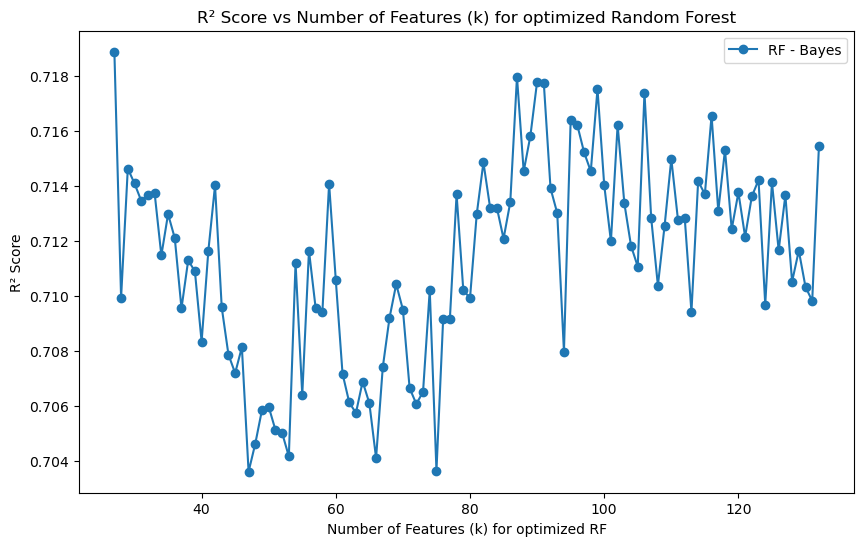

In [73]:
# Best parameters:([('max_depth', 34), ('max_features', 11), ('max_samples', 1.0), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000), ('oob_score', False), ('warm_start', False)])
feature_counts_opt = range(27, 133, 1)
results_rf_bayes_opt = {}

# --- Random Forest ---
for k in feature_counts_opt:
    selected_features = shap_series_rf.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned RF (for 27 features in the dataset)
    model_rf_bayes = RandomForestRegressor(random_state=42, verbose=0,
                                           n_estimators=1000,
                                           max_depth=34,           # the default value is None, which means nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
                                           max_features=11,        # the default value is 1.0, which means the full dataset is used. 11 is close to the square root of the total features in the original dataset .
                                           min_samples_split=2,    # the default value is 2
                                           min_samples_leaf=1,     # the default value is 1
                                           max_samples=1.0,        # the default value is None, which means the full dataset is used. 1.0 means the full dataset is used.
                                           oob_score= False,       # the default value is False, which means out-of-bag samples are not used for validation.
                                           warm_start= False       # the default value is False, which means the model is not warm-started.
                                           )

    model_rf_bayes.fit(X_train_k, y_train)
    preds_rf_bayes = model_rf_bayes.predict(X_test_k)
    results_rf_bayes_opt[k] = r2_score(y_test, preds_rf_bayes)

top_3_feat_choice_opt = sorted(results_rf_bayes_opt.items(), key=lambda x: x[1], reverse=True)[:3]

print("🔝 Top 3 feature_sets chosen by the optmized RF model with R² score:")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_opt, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")
   
plt.figure(figsize=(10, 6))
plt.plot(feature_counts_opt, list(results_rf_bayes_opt.values())  , label="RF - Bayes", marker='o')
plt.xlabel("Number of Features (k) for optimized RF")
plt.title("R² Score vs Number of Features (k) for optimized Random Forest")
plt.ylabel("R² Score")
plt.legend()

2. XGBoost optimized model and optimized featureset

🔝 Top 3 feature_sets chosen by the optmized XGBoost model with R² score :
1. k = 63, R² = 0.7764
2. k = 104, R² = 0.7707
3. k = 106, R² = 0.7701


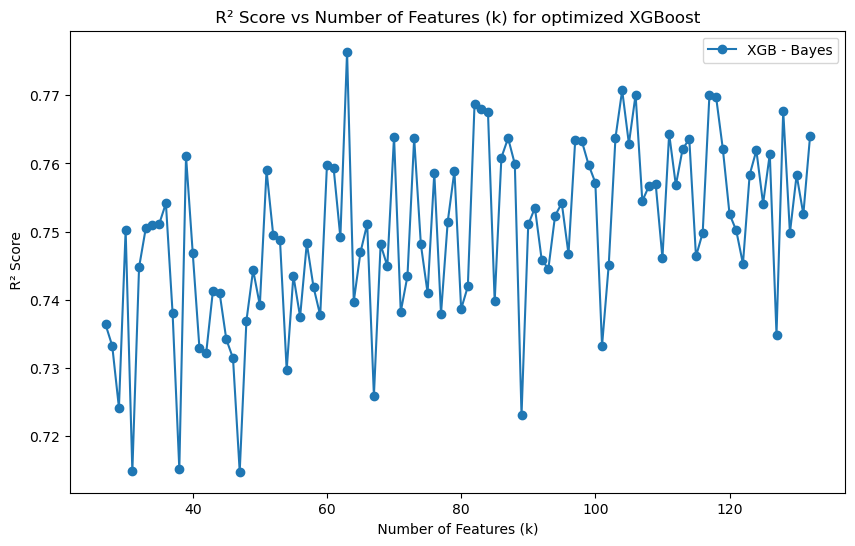

In [71]:
# Best parameters found: ([('colsample_bytree', 0.35638495679812116), ('gamma', 0.0), ('learning_rate', 0.13425429947962628),   
# ('max_depth', 33), ('n_estimators', 1000), ('reg_alpha', 0.3343417337155307), ('reg_lambda', 10.0), ('subsample', 0.9201475922066067)])
feature_counts_xgb = range(27, 133, 1)
results_xgb_bayes = {}
# --- XGBoost ---
for k in feature_counts_xgb:
    selected_features = shap_series_xgb.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned XGB (for 73 features in the dataset)
    model_xgb_bayes = XGBRegressor(random_state=42, verbosity=0,
                                    n_estimators=1000,
                                    max_depth=33,                             # the default value is 6 > the maximum depth of a tree is 6.
                                    learning_rate=0.13425429947962628,        # the default value is 0.3 > the learning rate is set to 0.13425429947962628.
                                    subsample=0.9201475922066067,             # the default value is 1.0 > the subsample ratio of the training instances is set to 0.9201475922066067.
                                    colsample_bytree= 0.35638495679812116,    # the default value is 1.0 > the subsample ratio of columns when constructing each tree is set to 0.35638495679812116.
                                    reg_alpha=0.3343417337155307,             # the default value is 0 > the L1 regularization term on weights is set to 0.3343417337155307.
                                    reg_lambda=10.0,                          # the default value is 1 > the L2 regularization term on weights is set to 10.0.
                                    gamma=0.0                                 # the default value is 0 > the minimum loss reduction required to make a further partition on a leaf node is set to 0.0.
                                    )
    model_xgb_bayes.fit(X_train_k, y_train)
    preds_xgb_bayes = model_xgb_bayes.predict(X_test_k)
    results_xgb_bayes[k] = r2_score(y_test, preds_xgb_bayes)

top_3_feat_choice_xgb = sorted(results_xgb_bayes.items(), key=lambda x: x[1], reverse=True)[:3]
print("🔝 Top 3 feature_sets chosen by the optmized XGBoost model with R² score :")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_xgb, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(feature_counts_xgb, list(results_xgb_bayes.values()), label="XGB - Bayes", marker='o')  
plt.xlabel(" Number of Features (k) ")
plt.title(" R² Score vs Number of Features (k) for optimized XGBoost ")
plt.ylabel(" R² Score")  
plt.legend()

3(a). LGBM optimized with best found featuresets for basic model

🔝 Top 3 feature_sets chosen by the optmized LGBM model with R² score:
1. k = 121, R² = 0.7666
2. k = 108, R² = 0.7645
3. k = 97, R² = 0.7631


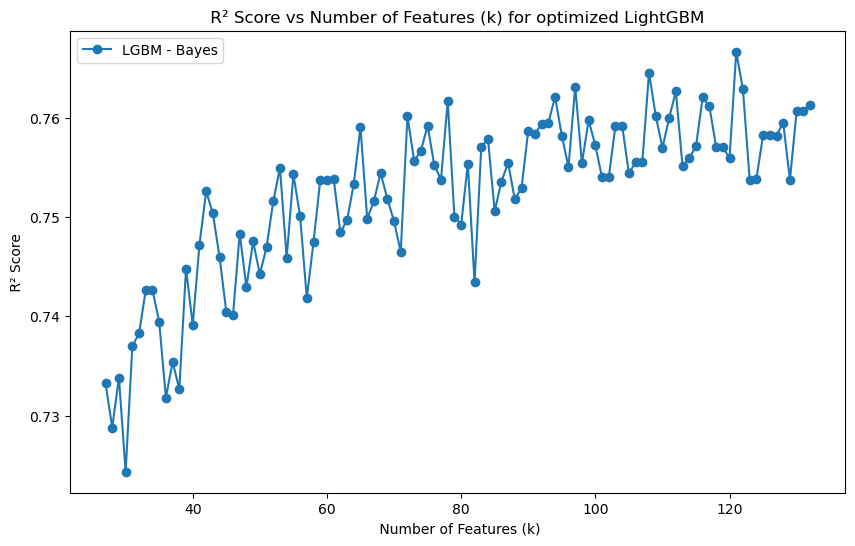

In [ ]:
#1. When started with Best  found (67) feature sets for not_optimized model:([('colsample_bytree', 0.5), ('learning_rate', 0.02149411536747437), ('max_depth', 33), ('min_child_samples', 20),  
#('n_estimators', 1000), ('num_leaves', 512), ('reg_alpha', 1e-08), ('reg_lambda', 1e-08), ('subsample', 0.5)])

feature_counts_lgbm = range(27, 133, 1)
results_lgbm_bayes= {}

for k in feature_counts_lgbm:
    selected_features = shap_series_lgbm.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned LGBM # (for 67 features in the dataset)
    model_lgbm_bayes = LGBMRegressor(random_state=42, verbosity=-1,
                                     learning_rate=0.02149411536747437,    # the default value is 0.1 > the learning rate is set to 0.02149411536747437.
                                     num_leaves=512,                       # the default value is 31 > the maximum number of leaves in one tree is set to 512.
                                     max_depth=33,                         # the default value is -1 (unlimited) > the maximum depth of a tree is set to 33.
                                     min_child_samples=20,                 # the default value is 20 > the minimum number of data points in a leaf node is set to 20.
                                     n_estimators=1000,                    # the default value is 100 > the number of boosting iterations is set to 1000.
                                     subsample=0.5,                        # the default value is 1.0 > the subsample ratio of the training instance is set to 0.5.
                                     colsample_bytree=0.5,                 # the default value is 1.0 > the subsample ratio of columns when constructing each tree is set to 0.5.
                                     reg_alpha=1e-08,                      # the default value is 0.0 > the L1 regularization term on weights is set to 1e-08. almost no regularization.
                                     reg_lambda=1e-08                      # the default value is 0.0 > the L2 regularization term on weights is set to 1e-08. almost no regularization.
                                     )
    
    model_lgbm_bayes.fit(X_train_k, y_train)
    preds_lgbm_bayes = model_lgbm_bayes.predict(X_test_k)
    results_lgbm_bayes[k] = r2_score(y_test, preds_lgbm_bayes)
    
top_3_feat_choice_lgbm = sorted(results_lgbm_bayes.items(), key=lambda x: x[1], reverse=True)[:3]
print("🔝 Top 3 feature_sets chosen by the optmized LGBM model with R² score:")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_lgbm, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")
    
plt.figure(figsize=(10, 6))
plt.plot(feature_counts_lgbm, list(results_lgbm_bayes.values()), label="LGBM - Bayes", marker='o')
plt.xlabel(" Number of Features (k)")
plt.ylabel(" R² Score ")
plt.title(" R² Score vs Number of Features (k) for optimized LightGBM ")
plt.legend()

3(b). #LGBM When started with random and intuitive 50% of initial featureset (66)

🔝 Top 3 feature_sets chosen by the optmized LGBM model (start:50% of initial features) with R² score:
1. k = 71, R² = 0.7748
2. k = 76, R² = 0.7735
3. k = 125, R² = 0.7733


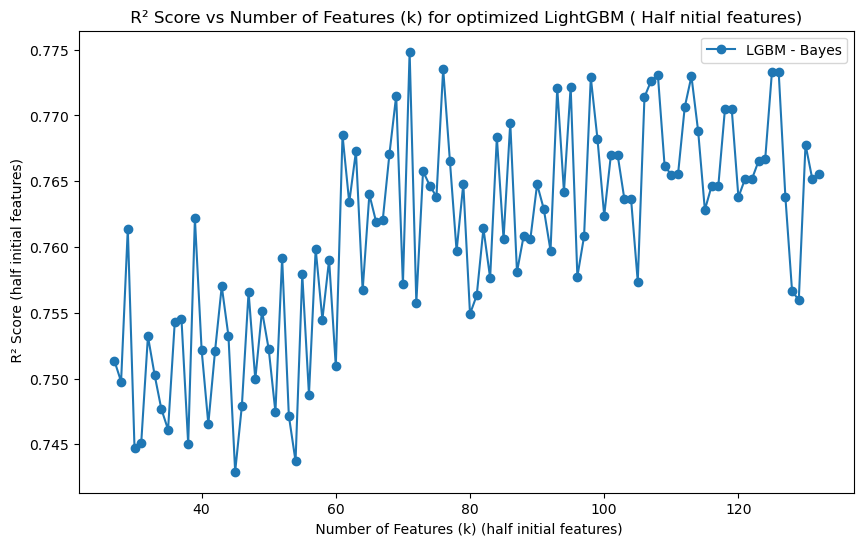

In [ ]:
# When started with random and intuitive 50% of initial featureset (66): ([('colsample_bytree', 0.5), ('learning_rate', 0.02805452532134942), ('max_depth', 34), ('min_child_samples', 20),  
#('n_estimators', 945), ('num_leaves', 31), ('reg_alpha', 1e-08), ('reg_lambda', 1e-08), ('subsample', 1.0)])
feature_counts_lgbm_50 = range(27, 133, 1)
results_lgbm_bayes_50= {}

for k in feature_counts_lgbm_50:
    selected_features = shap_series_lgbm.sort_values(ascending=False).head(k).index
    X_train_k = X_train[selected_features]
    X_test_k = X_test[selected_features]

    # Bayes-tuned LGBM # (for 66 features in the dataset)
    model_lgbm_bayes = LGBMRegressor(random_state=42, verbosity=-1,
                                     learning_rate=0.02805452532134942,    # the default value is 0.1 > the learning rate is set to 0.02149411536747437.
                                     num_leaves=31,                        # the default value is 31 > the maximum number of leaves in one tree is set to 512.
                                     max_depth=34,                         # the default value is -1 (unlimited) > the maximum depth of a tree is set to 33.
                                     min_child_samples=20,                 # the default value is 20 > the minimum number of data points in a leaf node is set to 20.
                                     n_estimators=945,                     # the default value is 100 > the number of boosting iterations is set to 1000.
                                     subsample=1.0,                        # the default value is 1.0 > the subsample ratio of the training instance is set to 0.5.
                                     colsample_bytree=0.5,                 # the default value is 1.0 > the subsample ratio of columns when constructing each tree is set to 0.5.
                                     reg_alpha=1e-08,                      # the default value is 0.0 > the L1 regularization term on weights is set to 1e-08. almost no regularization.
                                     reg_lambda=1e-08                      # the default value is 0.0 > the L2 regularization term on weights is set to 1e-08. almost no regularization.
                                     )
    
    model_lgbm_bayes.fit(X_train_k, y_train)
    preds_lgbm_bayes = model_lgbm_bayes.predict(X_test_k)
    results_lgbm_bayes_50[k] = r2_score(y_test, preds_lgbm_bayes)
    
top_3_feat_choice_lgbm_50 = sorted(results_lgbm_bayes_50.items(), key=lambda x: x[1], reverse=True)[:3]
print("🔝 Top 3 feature_sets chosen by the optmized LGBM model (start:50% of initial features) with R² score:")
for rank, (k_val, r2_val) in enumerate(top_3_feat_choice_lgbm_50, start=1):
    print(f"{rank}. k = {k_val}, R² = {r2_val:.4f}")
    
plt.figure(figsize=(10, 6))
plt.plot(feature_counts_lgbm_50, list(results_lgbm_bayes_50.values()), label="LGBM - Bayes", marker='o')
plt.xlabel(" Number of Features (k) (half initial features)")
plt.ylabel(" R² Score (half initial features)")
plt.title(" R² Score vs Number of Features (k) for optimized LightGBM ( Half nitial features) ")
plt.legend()

# Performance History and Comparision: 

** model name__initial No. of features__Bayesian heüerparameter training__Final No. Of Features **  

> Model Optimization steps (4) : No. Of features changes from : default > optimized (by r2 score) for default model ('opt-feat1' in the variable names)  >   
 Bayesian Hyperparameter Tuned optimized model > optimized (by r2 score) for Bayes optimized model ('opt-feat.' in the variable names) ** Only for LGBM model started with 50 features as opt-feat1 ended up giving better performance and smaller features set**  

>LGBM_full_Default = k = 132,  R² = 0.73184  
LGBM_50_opt_opt2 = k = 71, R² = 0.7748    
LGBM_opt-feat1_default= k = 67, R² = 0.7529  
LGBM_opt-feat1_opt = k = 67, R² = 0.7529  
LGBM_opt-feat1_opt_opt-feat2 =  k = 121, R² = 0.7666  


>XGB_full_Default = k = 132, R²  0.73488  
XGB_opt-feat1_default = k = 73,  R² = 0.7531  
XGB_opt-feat1_opt = k = 73, R² = 0.7516  
XGB_opt-feat1_opt_opt-feat2 = k = 63, R² = 0.7764  

>RF_full_Default = k = 132,  R² 0.7076  
RF_opt-feat1_default = k = 27, R² = 0.7218  
RF_opt-feat1_opt = k = 27, R² 0.7189  
RF_opt-feat1_opt_opt-feat2 = k = 27, R² = 0.7189  

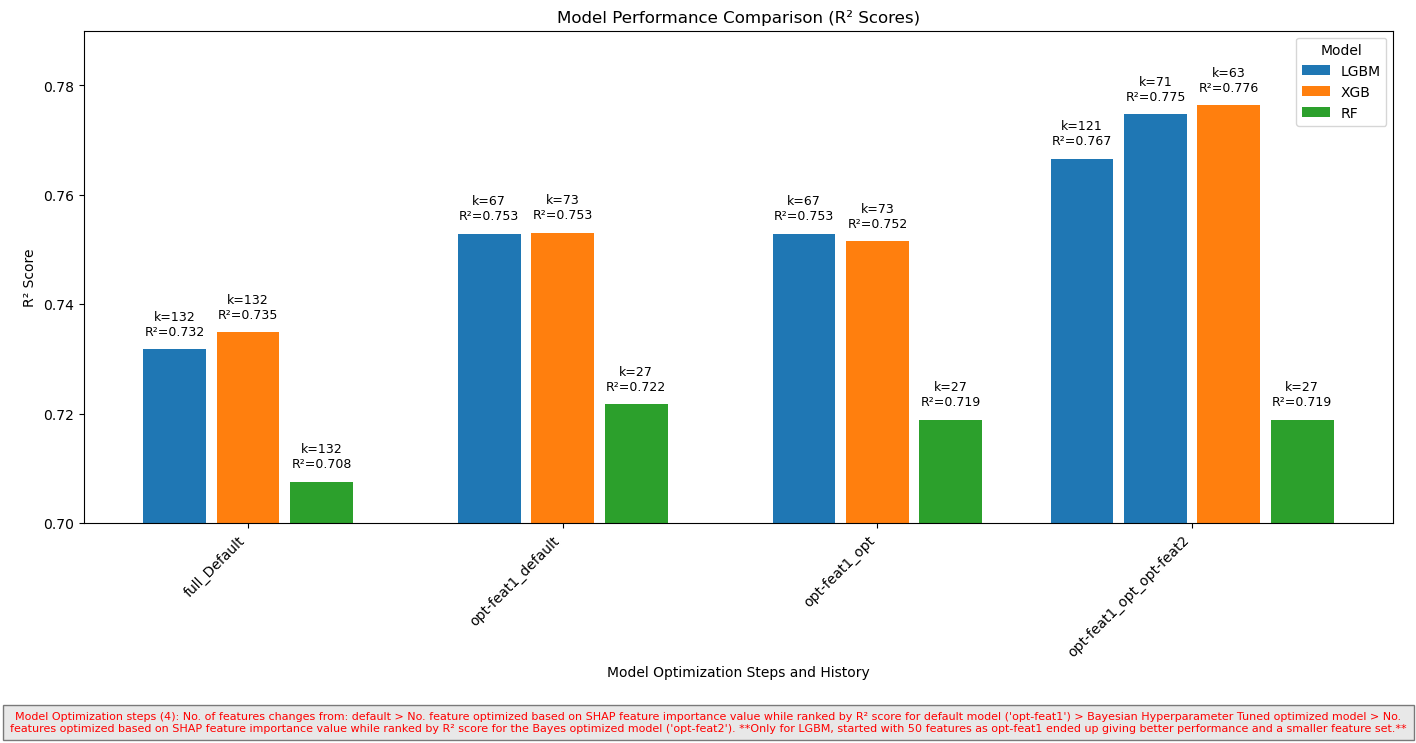

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare DataFrame
data = {
    "Model": [
        "LGBM", "LGBM", "LGBM", "LGBM-1", "LGBM-2",
        "XGB", "XGB", "XGB", "XGB",
        "RF", "RF", "RF", "RF"
    ],
    "Step": [
        "full_Default", "opt-feat1_default", "opt-feat1_opt", "opt-feat1_opt_opt-feat2", "opt-feat1_opt_opt-feat2",
        "full_Default", "opt-feat1_default", "opt-feat1_opt", "opt-feat1_opt_opt-feat2",
        "full_Default", "opt-feat1_default", "opt-feat1_opt", "opt-feat1_opt_opt-feat2"
    ],
    "k_features": [
        132, 67, 67, 121, 71,
        132, 73, 73, 63,
        132, 27, 27, 27
    ],
    "R2_score": [
        0.73184, 0.7529, 0.7529, 0.7666, 0.7748,
        0.73488, 0.7531, 0.7516, 0.7764,
        0.7076, 0.7218, 0.7189, 0.7189
    ]
}

df = pd.DataFrame(data)

# Define consistent parameters
step_labels = ["full_Default", "opt-feat1_default", "opt-feat1_opt", "opt-feat1_opt_opt-feat2"]
group_spacing = 1.5  # space between steps
bar_width = 0.3     # width of each bar
model_order = ["LGBM-1", "LGBM-2", "LGBM", "XGB", "RF"]
model_colors = {
    "LGBM": "#1f77b4",
    "LGBM-1": "#1f77b4",
    "LGBM-2": "#1f77b4",
    "XGB": "#ff7f0e",
    "RF": "#2ca02c"
}
legend_labels = {"LGBM": "LGBM", "XGB": "XGB", "RF": "RF"}

# Determine unique models at each step
models_per_step = {
    "full_Default": ["LGBM", "XGB", "RF"],
    "opt-feat1_default": ["LGBM", "XGB", "RF"],
    "opt-feat1_opt": ["LGBM", "XGB", "RF"],
    "opt-feat1_opt_opt-feat2": ["LGBM-1", "LGBM-2", "XGB", "RF"]
}

# Calculate x positions for each step
x_positions = []
for i, step in enumerate(step_labels):
    n_models = len(models_per_step[step])
    step_center = i * group_spacing
    offsets = []
    if n_models % 2 == 0:
        # Even number of bars
        start = - (n_models / 2 - 0.5) * (bar_width + 0.05)
        offsets = [start + j * (bar_width + 0.05) for j in range(n_models)]
    else:
        # Odd number of bars
        start = - (n_models // 2) * (bar_width + 0.05)
        offsets = [start + j * (bar_width + 0.05) for j in range(n_models)]
    for model, offset in zip(models_per_step[step], offsets):
        x_positions.append((step, model, step_center + offset))

# Plotting
plt.figure(figsize=(14, 7))
for (step, model, x) in x_positions:
    row = df[(df['Step'] == step) & (df['Model'] == model)]
    if row.empty:
        continue
    row = row.iloc[0]
    plt.bar(
        x,
        row['R2_score'],
        width=bar_width,
        color=model_colors.get(model, 'grey'),
        label=model if model in legend_labels else ""  # only label main models
    )
    plt.text(
        x,
        row['R2_score'] + 0.002,
        f'k={row["k_features"]}\nR²={row["R2_score"]:.3f}',
        ha='center', va='bottom', fontsize=9
    )

# X-axis labels
step_centers = [i * group_spacing for i in range(len(step_labels))]
plt.xticks(step_centers, step_labels, rotation=45, ha='right')
plt.ylabel("R² Score")
plt.xlabel("Model Optimization Steps and History")
plt.ylim(0.70, 0.79)
plt.title("Model Performance Comparison (R² Scores)")

# Legend (manually add unique entries)
handles = []
labels = []
for model, color in legend_labels.items():
    handles.append(plt.bar(0, 0, color=model_colors[model], label=model))
plt.legend(handles, legend_labels.values(), title="Model")

# Annotation
note = (
    "Model Optimization steps (4): No. of features changes from: default > "
    "No. feature optimized based on SHAP feature importance value while ranked by R² score for default model ('opt-feat1') > "
    "Bayesian Hyperparameter Tuned optimized model > No. features optimized based on SHAP feature importance value while ranked by R² score for the Bayes optimized model ('opt-feat2'). "
    "**Only for LGBM, started with 50 features as opt-feat1 ended up giving better performance and a smaller feature set.**"
)
plt.figtext(0.5, -0.05, note, wrap=True, horizontalalignment='center', fontsize=8, color='red',
            bbox={"facecolor": "lightgrey", "alpha": 0.5, "pad": 5})

plt.tight_layout()
plt.show()

In [ ]:
#     # Optuna-tuned RF
#     model_rf_optuna = RandomForestRegressor(**optuna_rf_study.best_params, random_state=42)
#     model_rf_optuna.fit(X_train_k, y_train)
#     preds_rf_optuna = model_rf_optuna.predict(X_test_k)
#     results_rf_optuna[k] = r2_score(y_test, preds_rf_optuna)



#     # Optuna-tuned XGB
#     model_xgb_optuna = XGBRegressor(**optuna_xgb_study.best_params, random_state=42, verbosity=0)
#     model_xgb_optuna.fit(X_train_k, y_train)
#     preds_xgb_optuna = model_xgb_optuna.predict(X_test_k)
#     results_xgb_optuna[k] = r2_score(y_test, preds_xgb_optuna)
    
#     # --- LightGBM ---


#     # Optuna-tuned LGBM
#     model_lgbm_optuna = LGBMRegressor(**optuna_lgbm_study.best_params, random_state=42, verbosity=0)
#     model_lgbm_optuna.fit(X_train_k, y_train)
#     preds_lgbm_optuna = model_lgbm_optuna.predict(X_test_k)
#     results_lgbm_optuna[k] = r2_score(y_test, preds_lgbm_optuna)

# # --- Plotting ---
# plt.figure(figsize=(14, 8))

# plt.plot(feature_counts, list(results_rf_bayes.values()), label="RF - Bayes", marker='o')
# plt.plot(feature_counts, list(results_rf_optuna.values()), label="RF - Optuna", marker='o')

# plt.plot(feature_counts, list(results_xgb_bayes.values()), label="XGB - Bayes", marker='s')
# plt.plot(feature_counts, list(results_xgb_optuna.values()), label="XGB - Optuna", marker='s')

# plt.plot(feature_counts, list(results_lgbm_bayes.values()), label="LGBM - Bayes", marker='^')
# plt.plot(feature_counts, list(results_lgbm_optuna.values()), label="LGBM - Optuna", marker='^')

# plt.xlabel("Number of Features")
# plt.ylabel("R² Score")
# plt.title("Feature Count Optimization for Tuned Models")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Retraining with optimized models

1.  XGBoost Final Model

In [ ]:
Features_XGB_Final = shap_series_xgb.sort_values(ascending=False).head(63).index
X_train_XGB_Final = X_train[Features_XGB_Final]
X_test_XGB_Final = X_test[Features_XGB_Final]

XGB_FINAL = XGBRegressor(random_state=42, verbosity=0,
                                    n_estimators=1000,
                                    max_depth=33,                             # the default value is 6 > the maximum depth of a tree is 6.
                                    learning_rate=0.13425429947962628,        # the default value is 0.3 > the learning rate is set to 0.13425429947962628.
                                    subsample=0.9201475922066067,             # the default value is 1.0 > the subsample ratio of the training instances is set to 0.9201475922066067.
                                    colsample_bytree= 0.35638495679812116,    # the default value is 1.0 > the subsample ratio of columns when constructing each tree is set to 0.35638495679812116.
                                    reg_alpha=0.3343417337155307,             # the default value is 0 > the L1 regularization term on weights is set to 0.3343417337155307.
                                    reg_lambda=10.0,                          # the default value is 1 > the L2 regularization term on weights is set to 10.0.
                                    gamma=0.0                                 # the default value is 0 > the minimum loss reduction required to make a further partition on a leaf node is set to 0.0.
                                    )
# # Train
XGB_FINAL.fit(X_train_XGB_Final, y_train)

# # Predict 
y_pred_XGB_Final = XGB_FINAL.predict(X_test_XGB_Final)

# # Evaluate & Report

r2_XGB_Final = r2_score(y_test,  y_pred_XGB_Final)
print("R²_XGB (final model):", r2_XGB_Final)

mae_XGB_Final = mean_absolute_error(y_test, y_pred_XGB_Final)
print("MAE_XGB (final model):", mae_XGB_Final)

R²_XGB (final model): 0.7763797044754028
MAE_XGB (final model): 0.40318426489830017


# Lightgbm Final Model

In [25]:
Features_LGBM_Final = shap_series_lgbm.sort_values(ascending=False).head(71).index
X_train_LGBM_Final = X_train[Features_LGBM_Final]
X_test_LGBM_Final = X_test[Features_LGBM_Final]

LGBM_FINAL = LGBMRegressor(random_state=42, verbosity=-1,
                                     learning_rate=0.02805452532134942,    # the default value is 0.1 > the learning rate is set to 0.02149411536747437.
                                     num_leaves=31,                        # the default value is 31 > the maximum number of leaves in one tree is set to 512.
                                     max_depth=34,                         # the default value is -1 (unlimited) > the maximum depth of a tree is set to 33.
                                     min_child_samples=20,                 # the default value is 20 > the minimum number of data points in a leaf node is set to 20.
                                     n_estimators=945,                     # the default value is 100 > the number of boosting iterations is set to 1000.
                                     subsample=1.0,                        # the default value is 1.0 > the subsample ratio of the training instance is set to 0.5.
                                     colsample_bytree=0.5,                 # the default value is 1.0 > the subsample ratio of columns when constructing each tree is set to 0.5.
                                     reg_alpha=1e-08,                      # the default value is 0.0 > the L1 regularization term on weights is set to 1e-08. almost no regularization.
                                     reg_lambda=1e-08                      # the default value is 0.0 > the L2 regularization term on weights is set to 1e-08. almost no regularization.
                                     )
# # Train
LGBM_FINAL.fit(X_train_LGBM_Final, y_train)

# # Predict 
y_pred_LGBM_Final = LGBM_FINAL.predict(X_test_LGBM_Final)

# # Evaluate & Report
r2_LGBM_Final = r2_score(y_test,  y_pred_LGBM_Final)
print("R²_LGBM (final model):", r2_LGBM_Final)

mae_LGBM_Final = mean_absolute_error(y_test, y_pred_LGBM_Final)
print("MAE_LGBM (final model):", mae_LGBM_Final)

R²_LGBM (final model): 0.7748416512139886
MAE_LGBM (final model): 0.4175146561404039


# Random_Forest_Regressor Final Model

In [24]:
Features_RF_Final = shap_series_rf.sort_values(ascending=False).head(27).index
X_train_RF_Final = X_train[Features_RF_Final]
X_test_RF_Final = X_test[Features_RF_Final]

RF_FINAL = RandomForestRegressor(random_state=42, verbose=0,
                                           n_estimators=1000,
                                           max_depth=34,           # the default value is None, which means nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
                                           max_features=11,        # the default value is 1.0, which means the full dataset is used. 11 is close to the square root of the total features in the original dataset .
                                           min_samples_split=2,    # the default value is 2
                                           min_samples_leaf=1,     # the default value is 1
                                           max_samples=1.0,        # the default value is None, which means the full dataset is used. 1.0 means the full dataset is used.
                                           oob_score= False,       # the default value is False, which means out-of-bag samples are not used for validation.
                                           warm_start= False       # the default value is False, which means the model is not warm-started.
                                           )
# # Train
RF_FINAL.fit(X_train_RF_Final, y_train)

# # Predict 
y_pred_RF_Final = RF_FINAL.predict(X_test_RF_Final)

# # Evaluate & Report
r2_RF_Final = r2_score(y_test,  y_pred_RF_Final)
print("R²_RF (final model):", r2_RF_Final)

mae_RF_Final = mean_absolute_error(y_test, y_pred_RF_Final)
print("MAE_RF (final model):", mae_RF_Final)

R²_RF (final model): 0.718889149714212
MAE_RF (final model): 0.46357587309874415


# Models generalizability

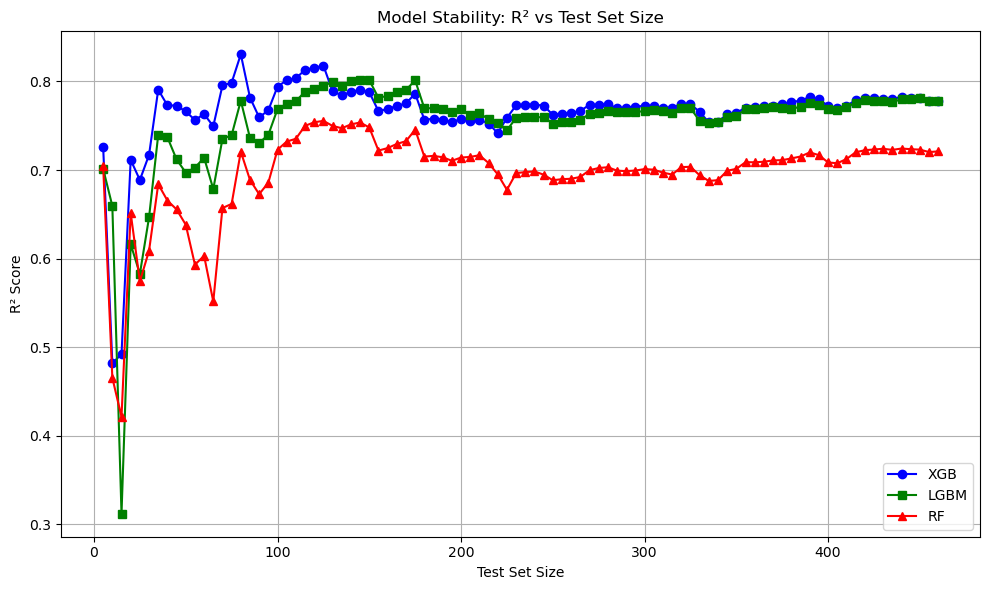

In [27]:
# ---- XGB Model ----
y_pred_XGB_Final = XGB_FINAL.predict(X_test_XGB_Final)
test_sizes_XGB = []
r2_scores_XGB = []

for size in range(5, len(y_test) + 1, 5):
    y_test_slice = y_test[:size]
    y_pred_slice = y_pred_XGB_Final[:size]
    r2 = r2_score(y_test_slice, y_pred_slice)
    test_sizes_XGB.append(size)
    r2_scores_XGB.append(r2)

# ---- LGBM Model ----
y_pred_LGBM_Final = LGBM_FINAL.predict(X_test_LGBM_Final)
test_sizes_LGBM = []
r2_scores_LGBM = []

for size in range(5, len(y_test) + 1, 5):
    y_test_slice = y_test[:size]
    y_pred_slice = y_pred_LGBM_Final[:size]
    r2 = r2_score(y_test_slice, y_pred_slice)
    test_sizes_LGBM.append(size)
    r2_scores_LGBM.append(r2)

# ---- RF Model ----
y_pred_RF_Final = RF_FINAL.predict(X_test_RF_Final)
test_sizes_RF = []
r2_scores_RF = []

for size in range(5, len(y_test) + 1, 5):
    y_test_slice = y_test[:size]
    y_pred_slice = y_pred_RF_Final[:size]
    r2 = r2_score(y_test_slice, y_pred_slice)
    test_sizes_RF.append(size)
    r2_scores_RF.append(r2)

# ---- Plot Results ----
plt.figure(figsize=(10, 6))
plt.plot(test_sizes_XGB, r2_scores_XGB, marker='o', linestyle='-', color='blue', label='XGB')
plt.plot(test_sizes_LGBM, r2_scores_LGBM, marker='s', linestyle='-', color='green', label='LGBM')
plt.plot(test_sizes_RF, r2_scores_RF, marker='^', linestyle='-', color='red', label='RF')
plt.xlabel('Test Set Size')
plt.ylabel('R² Score')
plt.title('Model Stability: R² vs Test Set Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance Comparision

In [28]:
explainer_rf_final= shap.TreeExplainer(RF_FINAL)
shap_values_rf_final = explainer_rf_final(X_test_RF_Final)

explainer_xgb_final = shap.TreeExplainer(XGB_FINAL)
shap_values_xgb_final = explainer_xgb_final.shap_values(X_test_XGB_Final)

explainer_lgbm_final = shap.TreeExplainer(LGBM_FINAL)
shap_values_lgbm_final = explainer_lgbm_final.shap_values(X_test_LGBM_Final)

In [34]:
import shap
import matplotlib.pyplot as plt

# Save Default Model plot
shap.summary_plot(shap_values_rf, X_test, show=False)
plt.title("Random Forest - Default")
plt.savefig("rf_default_shap.png", bbox_inches='tight')
plt.close()

# Save Optimized Model plot
shap.summary_plot(shap_values_rf_final, X_test_RF_Final, show=False)
plt.title("Random Forest - Optimized")
plt.savefig("rf_optimized_shap.png", bbox_inches='tight')
plt.close()
# XGBoost
shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title("XGBoost - Default")
plt.savefig("xgb_default_shap.png", bbox_inches='tight')
plt.close()

shap.summary_plot(shap_values_xgb_final, X_test_XGB_Final, show=False)
plt.title("XGBoost - Optimized")
plt.savefig("xgb_optimized_shap.png", bbox_inches='tight')
plt.close()

# LightGBM
shap.summary_plot(shap_values_lgbm, X_test, show=False)
plt.title("LightGBM - Default")
plt.savefig("lgbm_default_shap.png", bbox_inches='tight')
plt.close()

shap.summary_plot(shap_values_lgbm_final, X_test_LGBM_Final, show=False)
plt.title("LightGBM - Optimized")
plt.savefig("lgbm_optimized_shap.png", bbox_inches='tight')
plt.close()


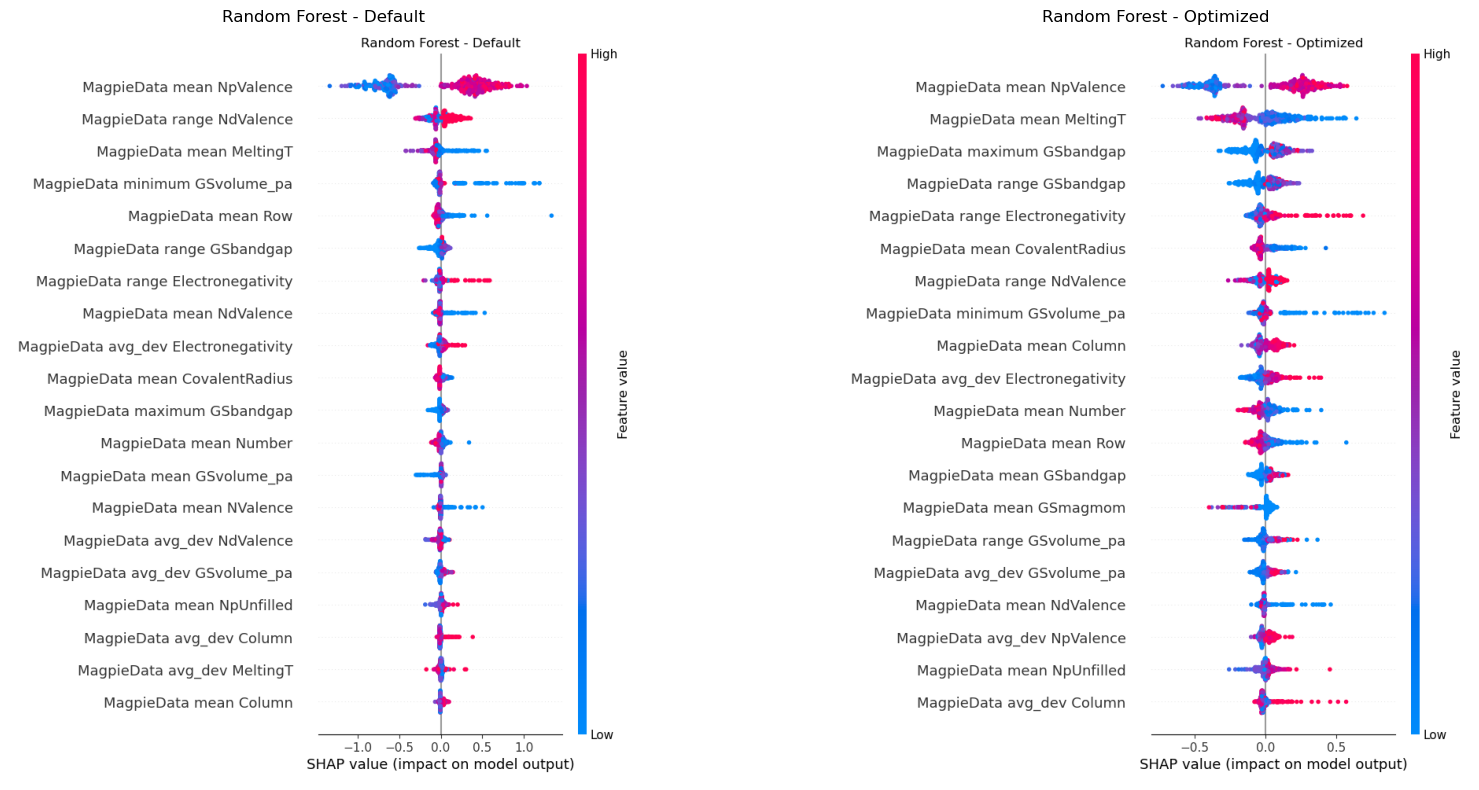

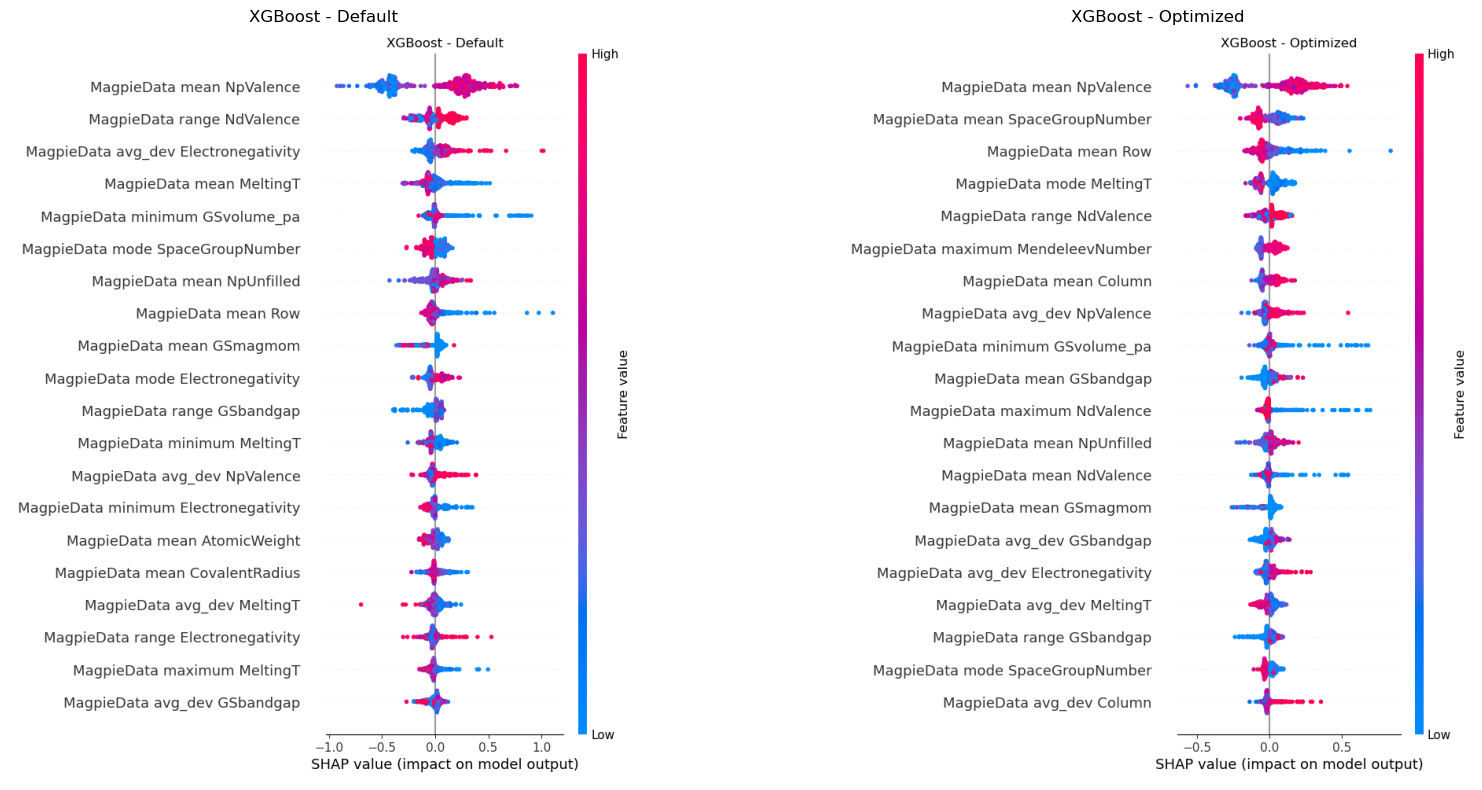

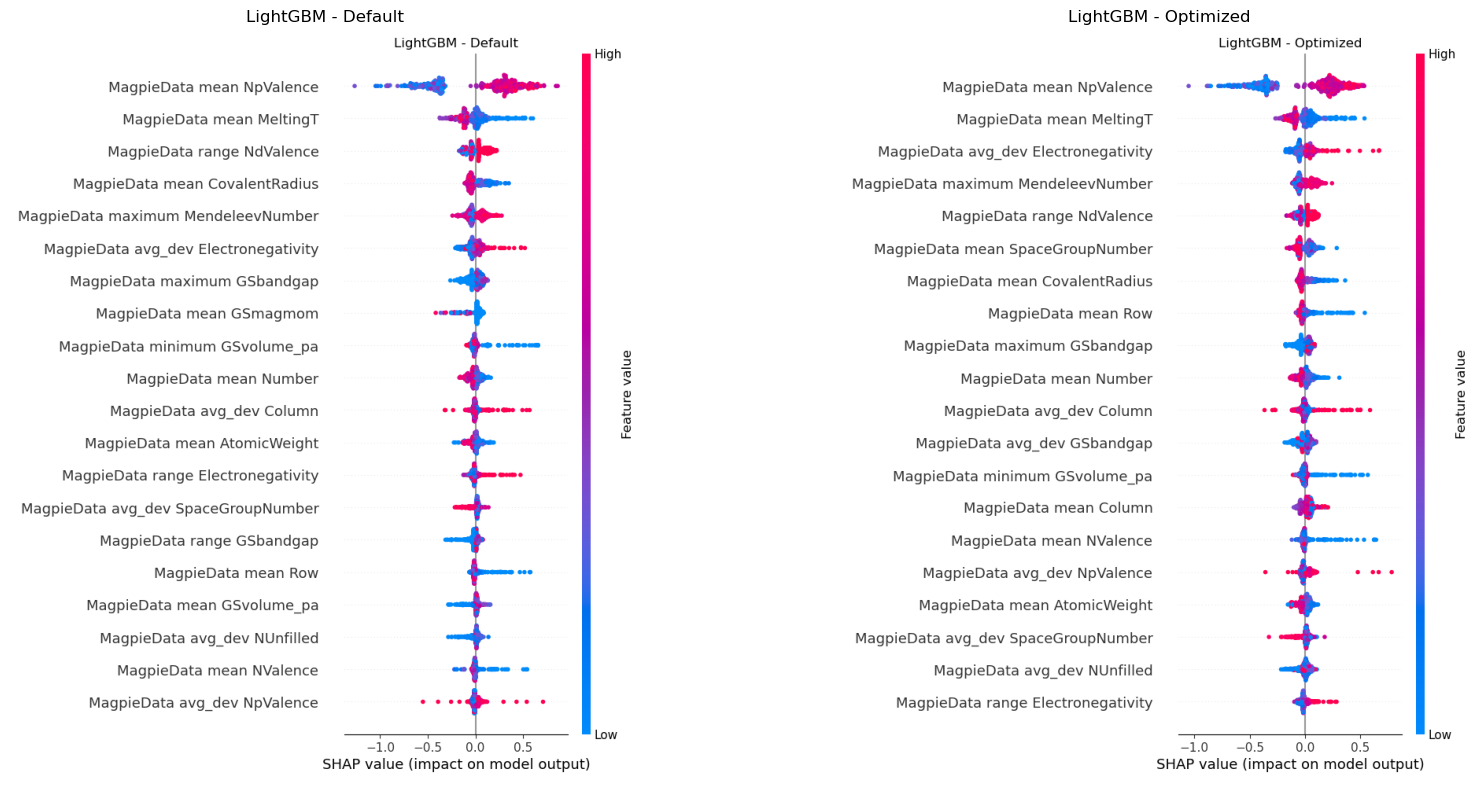

In [35]:

def plot_side_by_side(image_path1, image_path2, title):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    img1 = mpimg.imread(image_path1)
    img2 = mpimg.imread(image_path2)
    
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title(f"{title} - Default")
    
    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title(f"{title} - Optimized")
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_side_by_side("rf_default_shap.png", "rf_optimized_shap.png", "Random Forest")
plot_side_by_side("xgb_default_shap.png", "xgb_optimized_shap.png", "XGBoost")
plot_side_by_side("lgbm_default_shap.png", "lgbm_optimized_shap.png", "LightGBM")


In [ ]:
# # --- Save Outputs ---
# df_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
# df_results.to_csv("../results/bandgap_predictions.csv", index=False)